In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# === 資料讀取 ===
residual_df = pd.read_csv("2009_2025_fama_residual.csv", index_col=0, parse_dates=True)
return_raw = pd.read_excel("Return20240229.xlsx")

return_raw.columns = return_raw.columns.str.strip()
return_raw["年月日"] = pd.to_datetime(return_raw["年月日"])
return_raw["股票"] = return_raw["代號"].astype(str) + " " + return_raw["名稱"]
pivot_return = return_raw.pivot(index="年月日", columns="股票", values="日報酬率 %").sort_index()
residual_df.index = pd.to_datetime(residual_df.index)

# === 切割資料集 ===
train_residual = residual_df[residual_df.index < "2024-02-29"]
test_residual = residual_df[residual_df.index >= "2024-02-29"]
test_return = pivot_return[pivot_return.index >= "2024-02-29"]

# === 訓練集 ===
lookback = 30
X_list, y_list = [], []

for stock in train_residual.columns:
    series = train_residual[stock].dropna().values
    if len(series) <= lookback:
        continue
    for i in range(lookback, len(series) - 1):
        X_window = series[i - lookback:i]
        y_target = series[i]
        X_list.append(X_window)
        y_list.append(y_target)

X = np.array(X_list).reshape(-1, lookback, 1)
y = np.array(y_list).reshape(-1)

# === 測試集 ===
X_test_list, y_test_list, meta_list = [], [], []

for stock in test_residual.columns:
    series = test_residual[stock].dropna().values
    dates = test_residual[stock].dropna().index
    if len(series) <= lookback:
        continue
    for i in range(lookback, len(series) - 1):
        X_window = series[i - lookback:i]
        y_target = series[i]
        X_test_list.append(X_window)
        y_test_list.append(y_target)
        meta_list.append((dates[i], stock))

X_test = np.array(X_test_list).reshape(-1, lookback, 1)
y_test = np.array(y_test_list).reshape(-1)

# === 模型定義 ===
def sharpe_loss(y_true, y_pred):
    pnl = y_pred * y_true
    mean = tf.reduce_mean(pnl)
    std = tf.math.reduce_std(pnl)
    sharpe = mean / (std + 1e-6)
    return -sharpe

def build_model(input_len=30, cnn_filters=8, attn_heads=2, ff_dim=16):
    inp = layers.Input(shape=(input_len, 1))
    x = layers.Conv1D(filters=cnn_filters, kernel_size=3, padding='same', activation='relu')(inp)
    attn_out = layers.MultiHeadAttention(num_heads=attn_heads, key_dim=cnn_filters)(x, x)
    x = layers.Add()([x, attn_out])
    x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(ff_dim, activation='relu')(x)
    out = layers.Dense(1)(x)
    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss=sharpe_loss)
    return model

# === 模型訓練與預測 ===
model = build_model()
model.fit(X, y, epochs=10, batch_size=64)
y_pred = model.predict(X_test).flatten()

Epoch 1/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 169s 3ms/step - loss: -0.0105
Epoch 2/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 182s 4ms/step - loss: -0.0229
Epoch 3/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 163s 3ms/step - loss: -0.0251
Epoch 4/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 182s 4ms/step - loss: -0.0315
Epoch 5/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 191s 4ms/step - loss: -0.0321
Epoch 6/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 181s 4ms/step - loss: -0.0326
Epoch 7/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 177s 3ms/step - loss: -0.0331
Epoch 8/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 195s 4ms/step - loss: -0.0352
Epoch 9/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 189s 4ms/step - loss: -0.0337
Epoch 10/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 161s 3ms/step - loss: -0.0340
8348/8348 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


In [4]:
# 先建立 DataFrame 包含所有信號與報酬率資訊
pnl_df = pd.DataFrame(meta_list, columns=["date", "stock"])
pnl_df["signal"] = y_pred

# 加入報酬率
returns_flat = []
for date, stock in zip(pnl_df["date"], pnl_df["stock"]):
    if stock in test_return.columns and date in test_return.index:
        returns_flat.append(test_return.loc[date, stock] / 100)
    else:
        returns_flat.append(np.nan)

pnl_df["return"] = returns_flat
pnl_df = pnl_df.dropna()

# 按照每天挑選 signal 最大的前 10 檔
top_n_df = pnl_df.groupby("date").apply(lambda x: x.nlargest(10, "signal")).reset_index(drop=True)
top_n_df["pnl"] = top_n_df["signal"] * top_n_df["return"]


C:\Users\open7\AppData\Local\Temp\ipykernel_41540\1119921027.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_n_df = pnl_df.groupby("date").apply(lambda x: x.nlargest(10, "signal")).reset_index(drop=True)


In [5]:
top_n_df

,date,stock,signal,return,pnl
0,2024-04-15,2102 泰豐,7.435385,-0.011019,-0.081931
1,2024-04-15,3040 遠見,7.290043,0.000000,0.000000
2,2024-04-15,1423 利華,7.031313,0.000000,0.000000
3,2024-04-15,2881 富邦金,6.917958,-0.005900,-0.040816
4,2024-04-15,1708 東鹼,6.671893,0.001623,0.010828
...,...,...,...,...,...
2685,2025-05-23,2851 中再保,5.433650,0.001942,0.010552
2686,2025-05-23,2634 漢翔,5.334281,-0.005643,-0.030101
2687,2025-05-23,1102 亞泥,5.284756,-0.009227,-0.048762
2688,2025-05-23,1589 永冠-KY,5.260894,-0.015789,-0.083064


In [15]:
top_n_df.to_excel('top_n_df.xlsx')

C:\Users\open7\AppData\Local\Temp\ipykernel_41540\1426978892.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  softmax_df = top_n_df.groupby("date").apply(market_neutral_softmax).reset_index(drop=True)


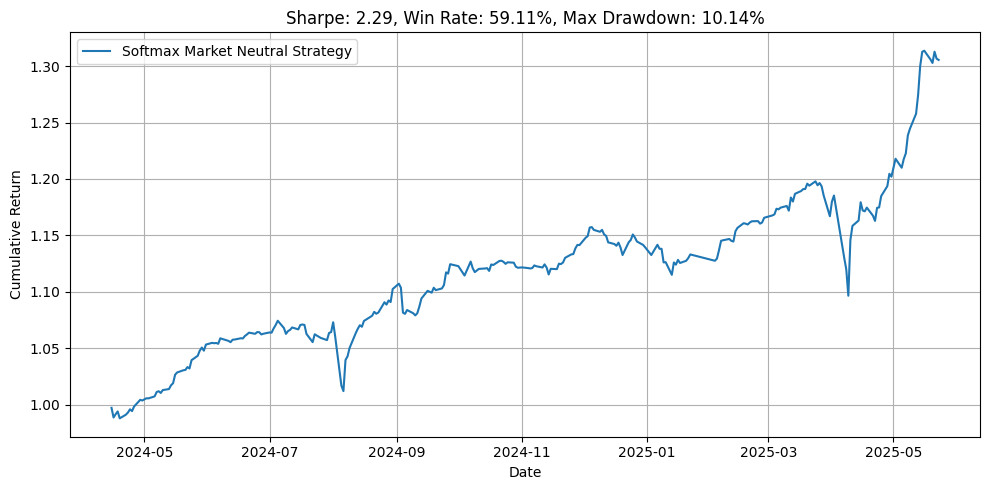

In [25]:
from scipy.special import softmax

# 建立 PnL 基礎資料
pnl_df = pd.DataFrame(meta_list, columns=["date", "stock"])
pnl_df["signal"] = y_pred
returns_flat = []
for date, stock in zip(pnl_df["date"], pnl_df["stock"]):
    if stock in test_return.columns and date in test_return.index:
        returns_flat.append(test_return.loc[date, stock] / 100)
    else:
        returns_flat.append(np.nan)
pnl_df["return"] = returns_flat
pnl_df = pnl_df.dropna()

# 每日取10名（方便 softmax 中切分 long short）
top_n_df = pnl_df.groupby("date").apply(lambda x: x.nlargest(10, "signal")).reset_index(drop=True)

def select_long_short(group, n_long=10, n_short=10):
    long_candidates = group.nlargest(n_long, "signal")
    short_candidates = group.nsmallest(n_short, "signal")
    return pd.concat([long_candidates, short_candidates])

#top_n_df = pnl_df.groupby("date").apply(select_long_short).reset_index(drop=True)

# === Softmax + 市場中立 ===
def market_neutral_softmax(group):
    long_signals = group[group["signal"] > 0].copy()
    short_signals = group[group["signal"] < 0].copy()
    if not long_signals.empty:
        lw = softmax(long_signals["signal"].values)
        long_signals["weight"] = 0.5 * lw
    else:
        long_signals["weight"] = []
    if not short_signals.empty:
        sw = softmax(-short_signals["signal"].values)
        short_signals["weight"] = -0.5 * sw
    else:
        short_signals["weight"] = []
    return pd.concat([long_signals, short_signals])

softmax_df = top_n_df.groupby("date").apply(market_neutral_softmax).reset_index(drop=True)
softmax_df["pnl"] = softmax_df["weight"] * softmax_df["return"]


# 統計績效指標
daily_softmax_pnl = softmax_df.groupby("date")["pnl"].sum()
cumulative_softmax_return = (1 + daily_softmax_pnl).cumprod()
win_rate = (daily_softmax_pnl > 0).sum() / len(daily_softmax_pnl)
cum_max = cumulative_softmax_return.cummax()
drawdown = cum_max - cumulative_softmax_return
max_drawdown = drawdown.max()
mean = daily_softmax_pnl.mean()
std = daily_softmax_pnl.std()
sharpe = (mean / (std + 1e-8)) * np.sqrt(252)

# 畫圖
plt.figure(figsize=(10, 5))
plt.plot(cumulative_softmax_return, label="Softmax Market Neutral Strategy")
plt.title(f"Sharpe: {sharpe:.2f}, Win Rate: {win_rate:.2%}, Max Drawdown: {max_drawdown:.2%}")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# 找出 2024-11 到 2025-01 的每日總損益以及貢獻最大的前幾筆交易
date_range = (daily_softmax_pnl.index >= "2025-03-01") & (daily_softmax_pnl.index <= "2025-05-20")
spike_dates = daily_softmax_pnl[date_range].sort_values(ascending=False).head(10).index.tolist()

# 篩選出這些日期的明細
spike_trades = softmax_df[softmax_df["date"].isin(spike_dates)].sort_values(by="pnl", ascending=False)

In [29]:
spike_trades

,date,stock,signal,return,weight,pnl
2600,2025-05-13,6591 動力-KY,5.552182,0.098720,0.083707,0.008264
2380,2025-04-10,1419 新紡,7.065221,0.075916,0.091588,0.006953
2610,2025-05-14,6861 睿生光電,5.098563,0.098196,0.062778,0.006165
2611,2025-05-14,4552 力達-KY,5.013982,0.098321,0.057686,0.005672
2381,2025-04-10,8443 阿瘦,6.863819,0.073171,0.074881,0.005479
...,...,...,...,...,...,...
2396,2025-04-11,1323 永裕,6.008855,-0.007519,0.038056,-0.000286
2533,2025-05-02,2884 玉山金,5.585621,-0.010601,0.046438,-0.000492
2606,2025-05-13,6657 華安,4.936978,-0.012698,0.045246,-0.000575
2392,2025-04-11,4133 亞諾法,6.513298,-0.010395,0.063024,-0.000655
